# Перемешиваем модальности

# Metadata
transforms, model+optimizer+loss, hyperparams

In [1]:
TITLE = "int+flip, contextnet+D-adan+dicefocal"

# Imports

In [2]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets.mri_preloaded import *
from glio.specific.mri_around import *
from glio.specific.vkr import *
from glio.transforms.intensity import RandScale, RandShift
from glio.transforms.spatial import RandFlipt

from glio.torch_tools import ConcatZeroChannelsToDataloader, BatchInputTransforms

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Dataset

In [3]:
bratstrain = get_ds_around(BRATS2024_NOHIST96_TRAIN) + get_ds_around(BRATS2024_NOHIST96_TEST)
rhuhtest = get_ds_around(RHUH_NOHIST140_NOADC_TRAIN) + get_ds_around(RHUH_NOHIST140_NOADC_TEST)

In [4]:

from monai import transforms as mtf

# fast tfms
gaussianblur = mtf.RandGaussianSmooth(prob=0.1) # type:ignore
contrast = mtf.RandAdjustContrast(gamma = (0.5, 2), prob=0.1) # type:ignore

# slower tfms
biasfield = mtf.RandBiasField(prob=0.1) # type:ignore
hist_shift = mtf.RandHistogramShift(prob=0.05) # type:ignore
gibbs = mtf.RandGibbsNoise(prob=0.1) # type:ignore
riccan = mtf.RandRicianNoise(std=0.5, prob=0.05) # type:ignore

# very slow
kspike = mtf.RandKSpaceSpikeNoise(prob=0.1) # type:ignore

def rand_shuffle_channels_around(x:torch.Tensor, channels_per = 3):
    if random.random() < 0.1:
        num_groups = int(x.shape[0] / channels_per)
        perm = torch.randperm(num_groups, dtype=torch.int32)
        img= x.reshape(num_groups, channels_per, *x.shape[1:])[perm].flatten(0, 1)
        return img
    return x

def rand_group_dropout(x):
    if random.random() < 0.05: return torch.zeros_like(x)
    if random.random() < 0.05: return torch.randn_like(x)
    return x

def randnoise(x):
    if random.random() < 0.1: return x + torch.randn_like(x) * random.triangular(0, 0.5, 0)
    return x


In [5]:
dstrain = DSToTarget(0)
dstest = DSToTarget(0)

dstrain.add_samples(bratstrain, loader_around_seq_fix, RandFlipt(p=0.5), get0, get1)
dstest.add_samples(rhuhtest, loader_around_seq, randcrop, get0, get1)
print(len(dstrain))
print(len(dstest))

332625
20893


# Performance

In [6]:
x = torch.randn((3,96,96))
with perf_counter_context():
    for i in range(100):
        dstrain[i]

Context took 0.2939172000042163 perf_counter seconds


# Inputs / targets preview

(<Figure size 2400x2400 with 4 Axes>,
 array([[<Axes: title={'center': 'inputs'}>,
         <Axes: title={'center': 'targets'}>],
        [<Axes: title={'center': 'inputs - test'}>,
         <Axes: title={'center': 'targets - test'}>]], dtype=object))

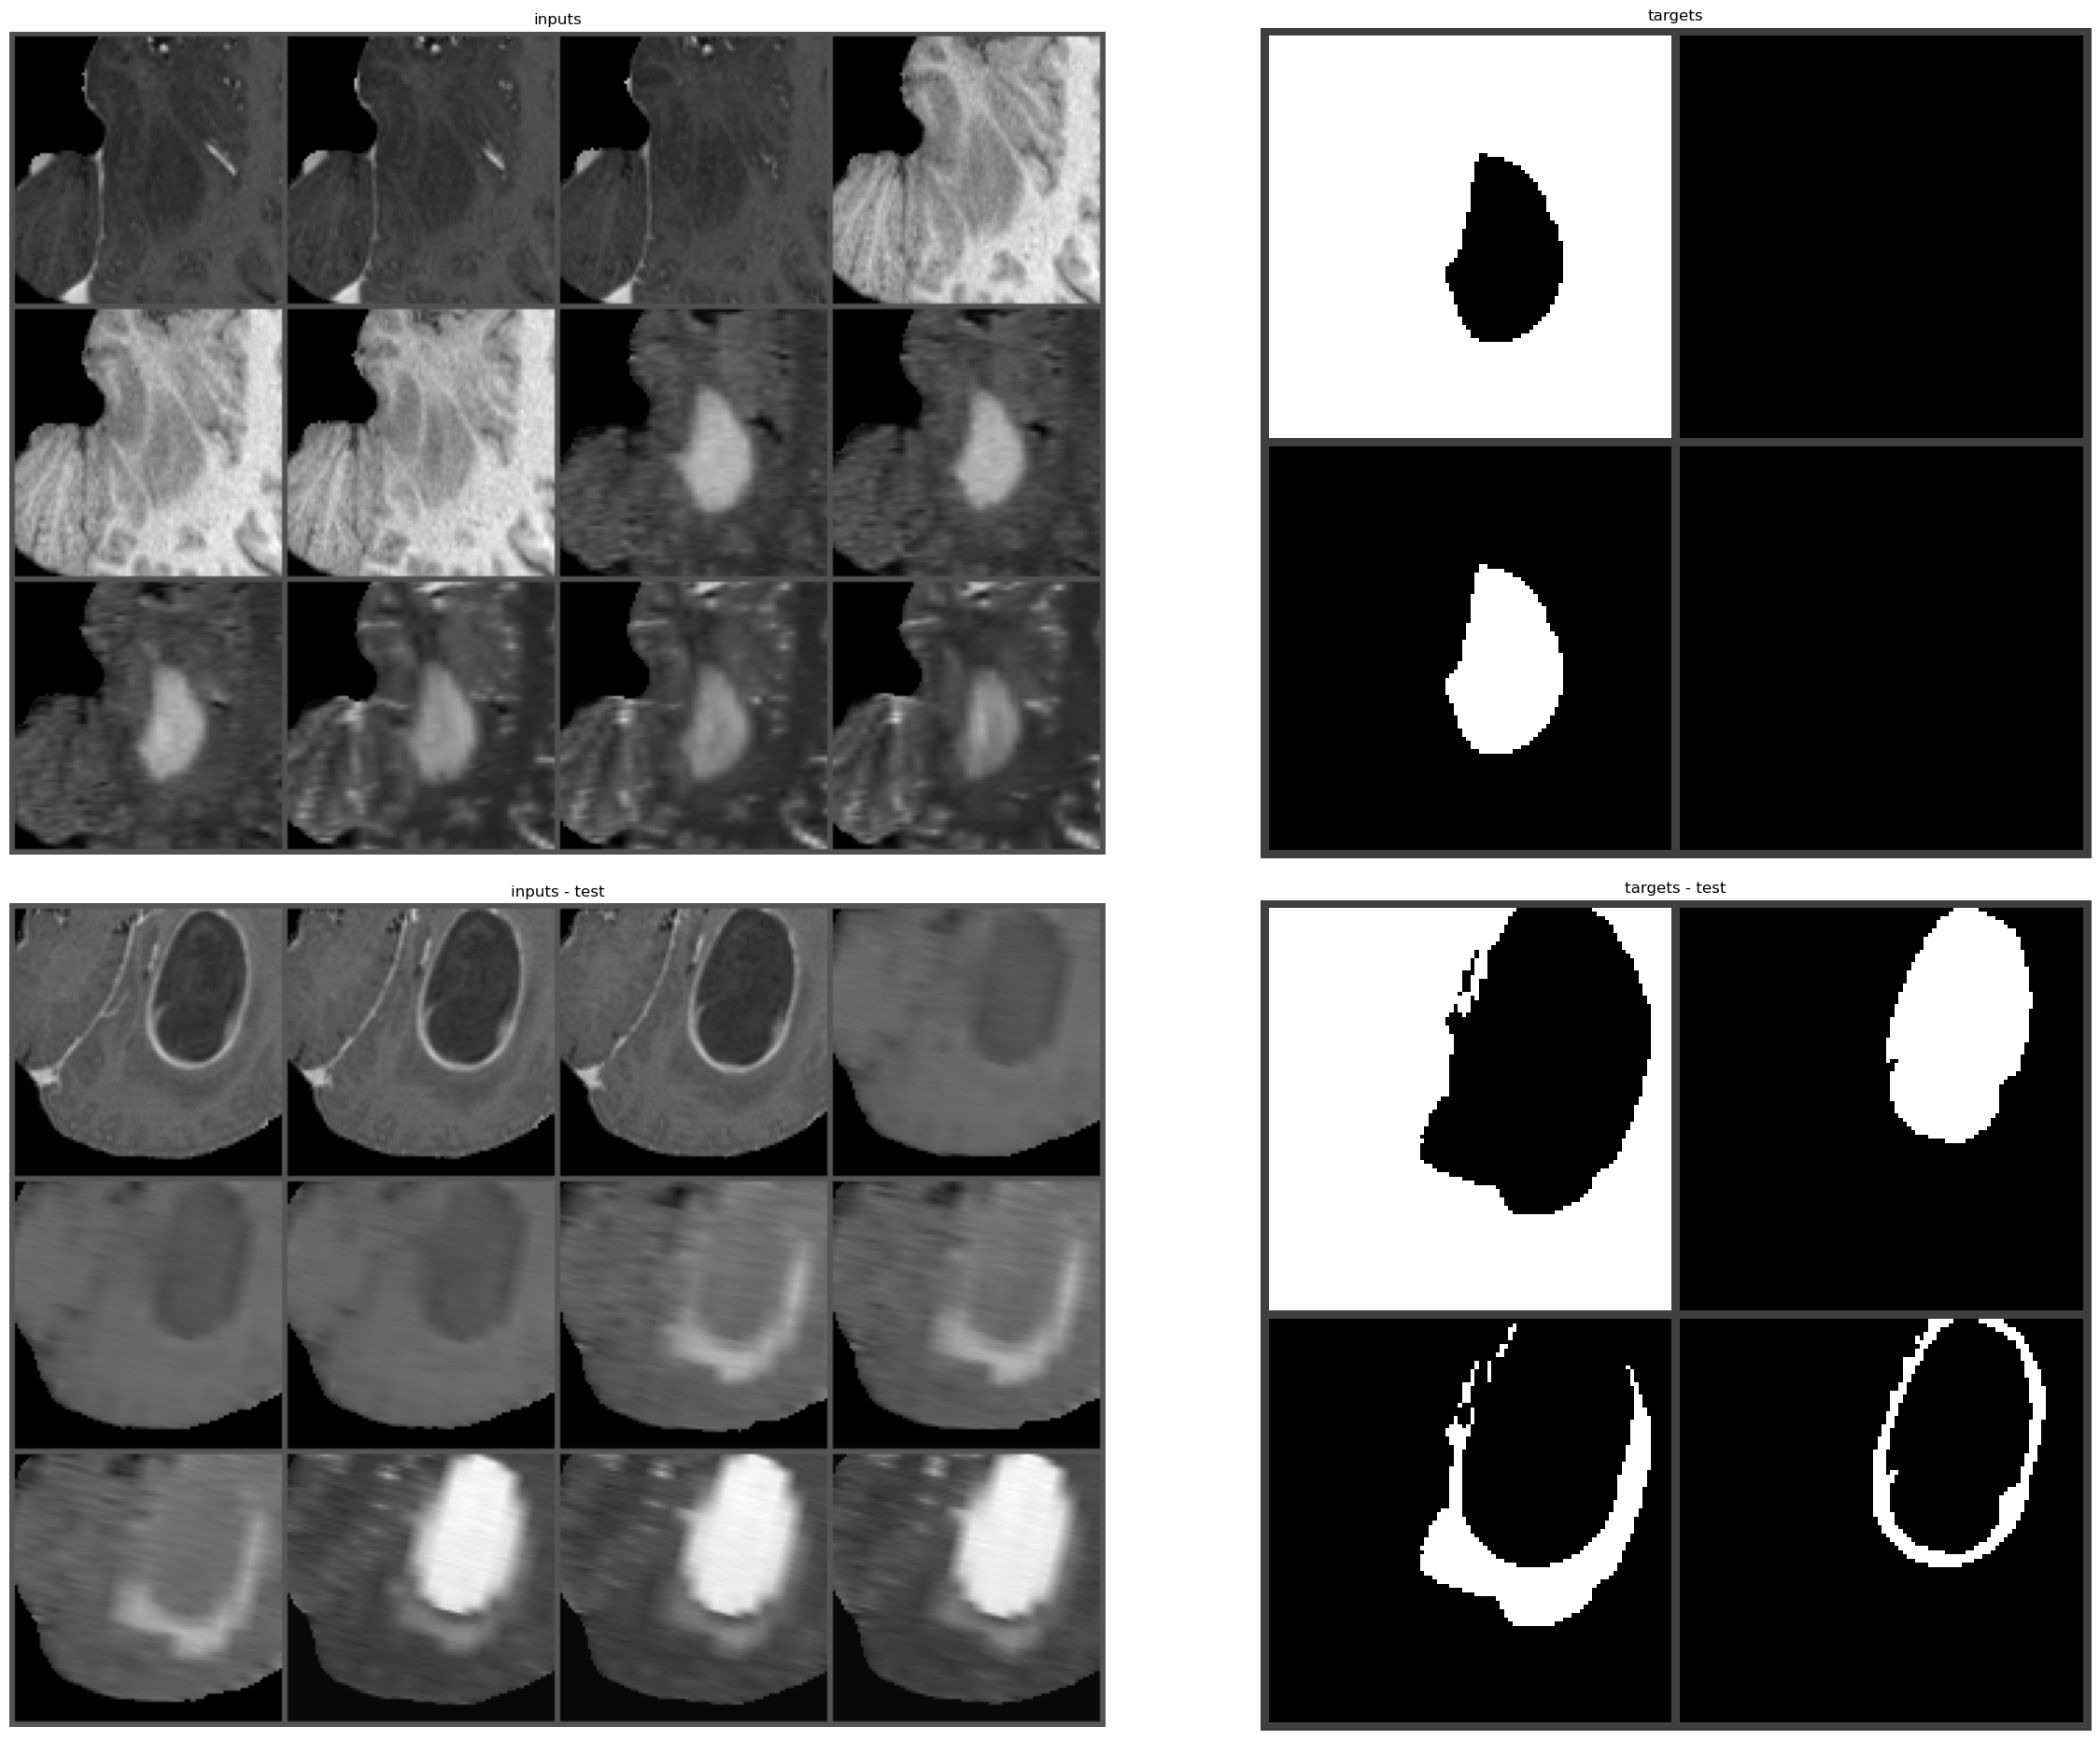

In [7]:
fig = Figure()
sample_ = dstrain[300]
fig.add().imshow_batch(sample_[0]).style_img('inputs')
fig.add().imshow_batch(sample_[1]).style_img('targets')
sample_ = dstest[20]
fig.add().imshow_batch(sample_[0]).style_img('inputs - test')
fig.add().imshow_batch(sample_[1]).style_img('targets - test')
fig.create(2, figsize=(24,24))

# Model

In [8]:
from monai.networks.nets import HighResNet # type:ignore
def HighResNet_noReLUattheend(in_channels=12, out_channels=20):
    model = HighResNet(2, in_channels, out_channels)
    model.blocks[-1].adn = nn.Identity()
    return model

single_tfms = Compose(rand_shuffle_channels_around, GroupwiseTfms((randnoise, RandScale(p=0.3, val=(0.75, 1.5)), RandShift(p=0.3, val=(-0.3, 0.3)), rand_group_dropout)))
batch_tfms = torch.vmap(single_tfms, randomness='different')

mse = torch.nn.MSELoss()

class ContextHRN(nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_tfms = batch_tfms
        self.hrn = HighResNet_noReLUattheend(12, 20)

    def forward(self, x:torch.Tensor):
        self.tfmed = self.batch_tfms(x)
        self.processed = self.hrn(self.tfmed)
        loss = mse(self.processed[:, :12], x)
        return self.processed[:,12:16], loss


summary(ContextHRN(), (4, 12, 96, 96))

path                                         module                                       input size               output size              params    buffers   
__main__.ContextHRN/hrn/blocks/0/conv        torch.nn.modules.conv.Conv2d                 (4, 12, 96, 96)          (4, 16, 96, 96)          1728      0         
__main__.ContextHRN/hrn/blocks/0/adn/N       torch.nn.modules.batchnorm.BatchNorm2d       (4, 16, 96, 96)          (4, 16, 96, 96)          32        33        
__main__.ContextHRN/hrn/blocks/0/adn/A       torch.nn.modules.activation.ReLU             (4, 16, 96, 96)          (4, 16, 96, 96)          0         0         
__main__.ContextHRN/hrn/blocks/1/layers/0/N  torch.nn.modules.batchnorm.BatchNorm2d       (4, 16, 96, 96)          (4, 16, 96, 96)          32        33        
__main__.ContextHRN/hrn/blocks/1/layers/0/A  torch.nn.modules.activation.ReLU             (4, 16, 96, 96)          (4, 16, 96, 96)          0         0         
__main__.ContextHRN/hrn/blocks/1/l

# Train

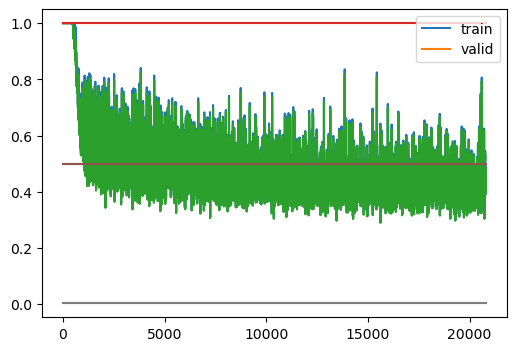

test loss: min: 1.6750; max: 3.0964; last: 1.6750                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
test iou: min: 0.0064; max: 0.5535; last: 0.5

In [9]:
from dadaptation import DAdaptAdan
from monai.losses import DiceFocalLoss # type:ignore

MODEL = ContextHRN()
NAME = f"{MODEL.__class__.__name__}"
LR = 1
BATCH_SIZE = 32
N_EPOCHS = 2

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = DAdaptAdan(MODEL.parameters(), lr=LR)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)
#SCHED = None

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(),
              Log_Time(), Save_Best(), Save_Last(), 
              #Log_LR(), 
              PerformanceTweaks(True), Accelerate("no"),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              MONAI_ConfusionMatrix(step=4), MONAI_ConfusionMatrixMetrics(),
              MONAI_ConfusionMatrix(step=4, include_bg = False, name="nobg confusion matrix"), MONAI_ConfusionMatrixMetrics(key = 'nobg confusion matrix', prefix='nobg '),
              FastProgressBar(step_batch=128, plot=True, metrics=('train loss', 'test loss', 'train dice loss', 'test dice loss',
                                                                  'test balanced accuracy', 'test nobg balanced accuracy',
                                                                  'test f1 score', 'test nobg f1 score'), maxv=1),
              Summary(),
              PlotSummary(path='summaries'),
              PrintLoss(),
              SaveReferenceVisualizationsAfterEachEpoch('reference preds'),
              Metric_PredsTargetsFn(LOSS_FN, name='dice loss'),
              #CallTrainAndEvalOnOptimizer(),
              AddLossReturnedByModelToLossInGetLoss(),
            )

LEARNER_NAME = f"{TITLE} lr{LR:.0e} OneCycleLR"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=True, test_on_interrupt=False)
plt.show()


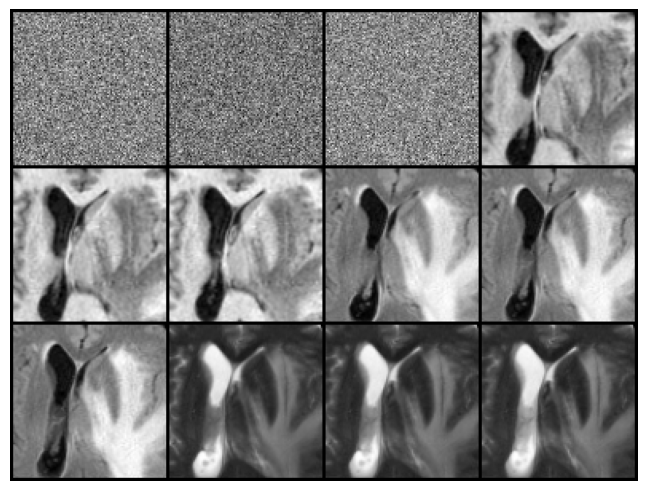

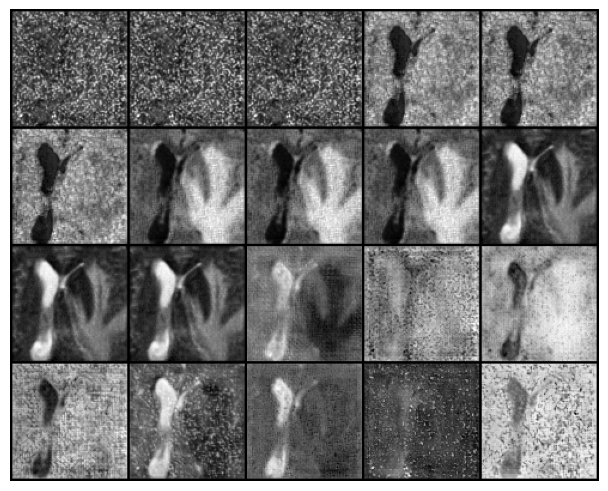

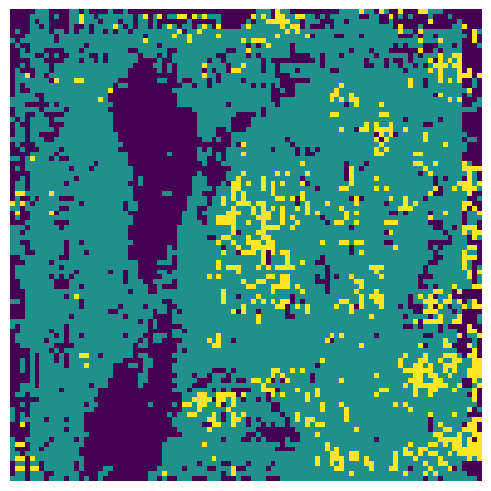

In [14]:
i=4
qimshow_batch(learner.model.tfmed[i], scale_each=True, maxelems=100)
qimshow_batch(learner.model.processed[i], scale_each=True, maxelems=100)
qimshow(learner.model.processed[i][-3:].argmax(0))